In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import string

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Load Amazon Dataset

Load the dataset consisting of baby product reviews on Amazon.com. Store the data in a data frame **products**.

In [4]:
products = pd.read_csv('./data/amazon_baby.csv')

In [5]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [6]:
products.shape

(183531, 3)

# Perform Text Cleaning

We start by removing punctuation, so that words "cake." and "cake!" are counted as the same word.

- Write a function **remove_punctuation** that strips punctuation from a line of text
- Apply this function to every element in the **review** column of **products**, and save the result to a new column **review_clean**.

**Aside.** In this notebook, we remove all punctuation for the sake of simplicity. A smarter approach to punctuation would preserve phrases such as "I'd", "would've", "hadn't" and so forth.

In [7]:
def remove_punctuation(text):
    tran_tab = str.maketrans('', '', string.punctuation)
    return text.translate(tran_tab) 

**MPORTANT.** Make sure to fill n/a values in the **review** column with empty strings (if applicable). The n/a values indicate empty reviews. For instance, Pandas's the fillna() method lets you replace all N/A's in the **review** columns.

In [8]:
products.fillna({'review':'', 'name':''}, inplace=True)

In [9]:
products['review_clean'] = products.review.apply(remove_punctuation)

# Extract Sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [10]:
idx = (products.rating != 3)
products = products[idx]

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label. A good way is to create an anonymous function that converts a rating into a class label and then apply that function to every element in the **rating** column.

In [11]:
products['sentiment'] = products.rating.apply(
    lambda rating: +1 if rating > 3 else -1
)

Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

In [12]:
products.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


# Train/Test Split

In [13]:
idx_train = pd.read_json('./data/module-2-assignment-train-idx.json')[0]
train_data = products.iloc[idx_train,:]

In [14]:
idx_test = pd.read_json('./data/module-2-assignment-test-idx.json')[0]
test_data = products.iloc[idx_test,:]

# Build the word count vector for each review

We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as **bag-of-word features**. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:

- Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction.
- Compute the occurrences of the words in each review and collect them into a row vector.
- Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix **train_matrix**.
- Using the same mapping between words and columns, convert the test data into a sparse matrix **test_matrix**.

The following cell uses CountVectorizer in scikit-learn. Notice the **token_pattern** argument in the constructor.

In [15]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

Keep in mind that the test data must be transformed in the same way as the training data.

# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data.

Learn a logistic regression classifier using the training data. If you are using scikit-learn, you should create an instance of the [LogisticRegression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and then call the method fit() to train the classifier. This model should use the sparse word count matrix (**train_matrix**) as features and the column **sentiment** of **train_data** as the target. Use the default values for other parameters. Call this model **sentiment_model**.

In [16]:
model = (
    LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=200).
    fit(train_matrix, train_data.sentiment)
)

# Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments. Compute the accuracy on the test set using your tool of choice.

In [17]:
accuracy = accuracy_score(y_true=test_data.sentiment, y_pred=model.predict(test_matrix))
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9322354211663066


# Baseline: Majority class prediction

It is quite common to use the majority class classifier as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should healthily beat the majority class classifier, otherwise, the model is (usually) pointless.

In [18]:
train_data.sentiment.value_counts()

 1    112164
-1     21252
Name: sentiment, dtype: int64

In [19]:
np.mean(test_data.sentiment == 1)

0.8427825773938085

# Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the confusion matrix. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
Using your tool, print out the confusion matrix for a classifier. For instance, scikit-learn provides the method confusion_matrix for this purpose.

In [20]:
cmat = confusion_matrix(y_true=test_data.sentiment,
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3787
     -1       |        1        |  1454
      1       |       -1        |   805
      1       |        1        | 27290


# Computing the cost of mistakes

Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints. Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, false positives cost more than false negatives. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake:

- \$100 for each false positive
- \$1 for each false negative.
- Correctly classified reviews incur no cost.

In [21]:
100 * cmat[0,1] + 1 * cmat[1,0]

146205

# Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where precision comes in.

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher.

First, let us compute the precision of the logistic regression classifier on the test_data. Scikit-learn provides a predefined method for computing precision. (Consult appropriate manuals if you are using other tools.)

In [22]:
precision = precision_score(y_true=test_data.sentiment, y_pred=model.predict(test_matrix))
print("Precision on test data", precision)

Precision on test data 0.9494155301976065


In [23]:
1 - precision

0.050584469802393506

A complementary metric is recall, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews.

Let us compute the recall on the test_data. Scikit-learn provides a predefined method for computing recall as well.

In [24]:
recall = recall_score(y_true=test_data.sentiment,
                      y_pred=model.predict(test_matrix))
print("Recall on test data:", recall)

Recall on test data: 0.9713472148069051


# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture. We first examine what happens when we use a different threshold value for making class predictions. We then explore a range of threshold values and plot the associated precision-recall curve.

# Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold.

Write a function called apply_threshold that accepts two things

- probabilities: an SArray of probability values
- threshold: a float between 0 and 1

The function should return an array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds threshold.

In [25]:
def apply_threshold(prob, threshold):
    return np.where(prob > threshold, 1, -1)

Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.

In [26]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [27]:
yhat_p5 = apply_threshold(probabilities, 0.5)
yhat_p9 = apply_threshold(probabilities, 0.9)

In [28]:
confusion_matrix(y_true=test_data.sentiment, y_pred=yhat_p5)

array([[ 3787,  1454],
       [  805, 27290]], dtype=int64)

In [29]:
confusion_matrix(y_true=test_data.sentiment, y_pred=yhat_p9)

array([[ 4776,   465],
       [ 3489, 24606]], dtype=int64)

In [30]:
np.sum(yhat_p5 == 1)

28744

In [31]:
np.sum(yhat_p9 == 1)

25071

By changing the probability threshold, it is possible to influence precision and recall. Compute precision and recall for threshold values 0.5 and 0.9.

In [32]:
precision_score(test_data.sentiment, yhat_p5)

0.9494155301976065

In [33]:
precision_score(test_data.sentiment, yhat_p9)

0.9814526744046906

In [34]:
recall_score(test_data.sentiment, yhat_p5)

0.9713472148069051

In [35]:
recall_score(test_data.sentiment, yhat_p9)

0.8758142018152696

# Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve. Use 100 equally spaced values between 0.5 and 1.

In [36]:
threshold_values = np.linspace(0.5, 0.999, num=100)

For each of the values of threshold, we first obtain class predictions using that threshold and then compute the precision and recall scores. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

In [37]:
precision_all = [precision_score(test_data.sentiment,
                                 apply_threshold(probabilities, t)) 
                 for t in threshold_values]
recall_all = [recall_score(test_data.sentiment,
                           apply_threshold(probabilities, t)) 
              for t in threshold_values]

Let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold. Implement the function plot_pr_curve that generates a connected scatter plot from the lists of precision and recall scores. The function would be implemented in matplotlib as follows; for other tools, consult appropriate manuals.

In [38]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

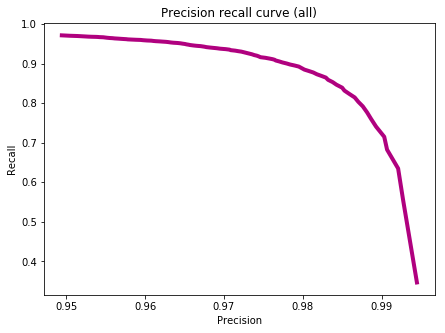

In [39]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [40]:
idx = np.argmax(np.array(precision_all) >= 0.965)
threshold_values[idx]

0.7066565656565656

Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

In [41]:
confusion_matrix(y_true=test_data.sentiment, 
                 y_pred=apply_threshold(probabilities, 0.98))

array([[ 5047,   194],
       [ 8214, 19881]], dtype=int64)

# Evaluating specific search terms

So far, we looked at the number of false positives for the entire test set. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

From the test set, select all the reviews for all products with the word 'baby' in them. If you are using SFrame, generate a binary mask with apply() and index test_data with the mask. Save the selection to a new data frame named baby_reviews.

In [42]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

Now, let's predict the probability of classifying these reviews as positive. Make sure to convert the column review_clean of baby_reviews into a 2D array before computing class probability values.

In [43]:
baby_reviews.head()

,name,review,rating,review_clean,sentiment
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
56,Baby's First Year Undated Wall Calendar with S...,I searched high and low for a first year calen...,5,I searched high and low for a first year calen...,1
59,Our Baby Girl Memory Book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
112,Newborn Baby Tracker&reg; - Round the Clock Ch...,This is the best way to keep track of when you...,5,This is the best way to keep track of when you...,1


In [44]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

Let's plot the precision-recall curve for the baby_reviews dataset. We again use 100 equally spaced values between 0.5 and 1 for the threshold.

In [45]:
threshold_values = np.linspace(0.5, 0.999, num=100)

For each of the values of threshold, we first obtain class predictions for baby_reviews using that threshold. Then we compute the precision and recall scores for baby_reviews. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

In [46]:
precision_all = [precision_score(baby_reviews.sentiment,
                                 apply_threshold(probabilities, t)) 
                 for t in threshold_values]
recall_all = [recall_score(baby_reviews.sentiment,
                           apply_threshold(probabilities, t)) 
              for t in threshold_values]

In [47]:
idx = np.argmax(np.array(precision_all) >= 0.965)
threshold_values[idx]

0.7318585858585859

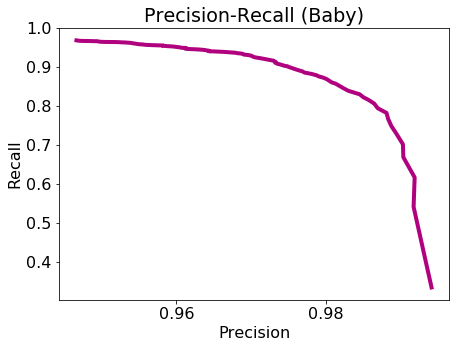

In [48]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")